In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets

import PIL
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
from skimage.io import imread
import os
smiles = []
root = '/content/drive/My Drive/Обучение машин/Проект Автоэнкодер'

for root, dirs, files in os.walk(os.path.join(root, 'smiles')):
    for file in files:
      smiles.append(imread(os.path.join(root, file)))

len(smiles)

600

In [5]:
from skimage.transform import resize
size = (64, 64)
smiles = [resize(x, size, mode='constant', anti_aliasing=True,) for x in smiles]
X = np.array(smiles, np.float32)
X = np.rollaxis(X, 3, 1)

ix = np.random.choice(len(X), len(X), False)
val, tr= np.split(ix, [120])

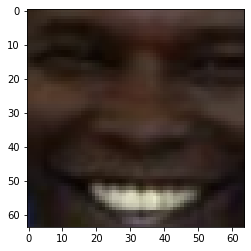

In [6]:

plt.imshow(np.rollaxis(X[599], 0, 3))


In [7]:
mean = np.mean(np.mean(np.mean(X, axis=0), axis=1), axis=1)
std = np.std(np.std(np.std(X, axis=0), axis=1), axis=1)


In [8]:
train_loader = torch.utils.data.DataLoader(X[tr], batch_size=128, shuffle = True)
val_loader = torch.utils.data.DataLoader(X[val], batch_size=120)
all_data = torch.utils.data.DataLoader(X, batch_size=128, shuffle = True)

In [58]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.pool0 =  nn.MaxPool2d(2,  padding=0) # 64 -> 32
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            )
        self.pool1 = nn.MaxPool2d(2, padding=0) # 32 -> 16
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            )
        self.pool2 = nn.MaxPool2d(2, padding=0) # 16 -> 8
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            )
        self.pool3 = nn.MaxPool2d(2, padding=0) # 8 -> 2

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU() 
        )

        
        # decoder (upsampling)
        self.upsample0 = nn.UpsamplingBilinear2d(8) # 2 -> 8
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            )
        self.upsample1 =  nn.UpsamplingBilinear2d(16)# 8 -> 16
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            )
        self.upsample2 =  nn.UpsamplingBilinear2d(32) # 16 -> 32
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            )
        self.upsample3 =  nn.UpsamplingBilinear2d(64) # 32 -> 64
        self.dec_conv3 =nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            # nn.ReLU(),
            )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b))
        d1 = self.dec_conv1(self.upsample1(d0))
        d2 = self.dec_conv2(self.upsample2(d1))
        d3 = self.dec_conv3(self.upsample3(d2)) 
        return d3

In [59]:
def train(model, device, trainloader, valloader, epochs=50, lr = 0.001):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, amsgrad=True)
    criterion = nn.MSELoss()
    lr_lambda = lambda epoch: 0.5
    scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda, last_epoch=-1)
    losses = []
    val_losses = []

    for e in range(epochs):
        epoch_loss = []
        #model.train()
        for image in trainloader:
            optimizer.zero_grad()

            output = model(image.to(device))

            loss = criterion(output, image.to(device)).cpu()
            epoch_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        if e+1 % 200 == 0:
             scheduler.step()
             print('LR changed') 

        '''
        model.eval()
        with torch.no_grad():

            for val in valloader:
                    
                output = model(val.to(device)).cpu()
                val_loss = criterion(output, val).cpu()
                

            losses.append(np.mean(epoch_loss)) 
            val_losses.append(val_loss)
'''
        losses.append(np.mean(epoch_loss)) 
        
        print(f'Epoch {e+1}, Train Loss {losses[-1]}, Valid Loss ')

    plt.plot(losses, label='train')
    plt.plot(val_losses, label='validation')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    return losses

In [60]:
from torchsummary import summary

model = AutoEncoder().to(device)

summary(model.to(device), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           9,248
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
         MaxPool2d-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          18,496
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,928
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
        MaxPool2d-14           [-1, 64,

Epoch 1, Train Loss 1.191230058670044, Valid Loss 
Epoch 2, Train Loss 1.0742949724197388, Valid Loss 
Epoch 3, Train Loss 1.037303614616394, Valid Loss 
Epoch 4, Train Loss 1.0126232147216796, Valid Loss 
Epoch 5, Train Loss 0.991778576374054, Valid Loss 
Epoch 6, Train Loss 0.9733593225479126, Valid Loss 
Epoch 7, Train Loss 0.9552452087402343, Valid Loss 
Epoch 8, Train Loss 0.9396116495132446, Valid Loss 
Epoch 9, Train Loss 0.9242096900939941, Valid Loss 
Epoch 10, Train Loss 0.9076725602149963, Valid Loss 
Epoch 11, Train Loss 0.8937251329421997, Valid Loss 
Epoch 12, Train Loss 0.8770243406295777, Valid Loss 
Epoch 13, Train Loss 0.8639948606491089, Valid Loss 
Epoch 14, Train Loss 0.8505667209625244, Valid Loss 
Epoch 15, Train Loss 0.8368313431739807, Valid Loss 
Epoch 16, Train Loss 0.8237183332443238, Valid Loss 
Epoch 17, Train Loss 0.8111068487167359, Valid Loss 
Epoch 18, Train Loss 0.7968192100524902, Valid Loss 
Epoch 19, Train Loss 0.784610915184021, Valid Loss 
Epoch 

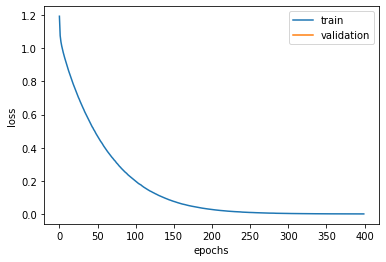

In [61]:
loss = train(model, device, all_data, val_loader, lr = 0.001  , epochs= 400)

In [64]:
test = torch.FloatTensor(X[400])[None, ::]
res = model(test.to(device))

res = np.array(res.cpu().detach()[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


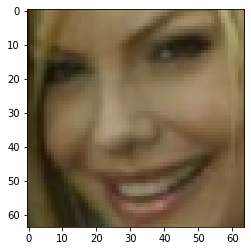

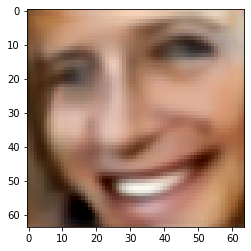

In [65]:
test = np.array(test[0])
test = np.rollaxis(test, 0, 3)

res = np.rollaxis(res, 0, 3)



plt.figure()
plt.imshow(test)

plt.figure()
plt.imshow(res)

In [66]:
no_smile = imread('/content/drive/My Drive/Обучение машин/Проект Автоэнкодер/No smiles/Xanana_Gusmao_0003.ppm')
no_smile = resize(no_smile, (64,64, 3), mode='constant', anti_aliasing=True,) 
res = model(torch.FloatTensor(np.rollaxis(no_smile, 2, 0))[None, ::].to(device)).cpu().detach()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


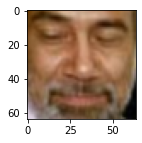

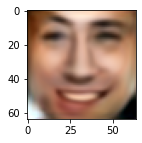

In [67]:
res = np.array(res[0])
plt.figure(figsize=(2,2))
plt.imshow(no_smile)

plt.figure(figsize=(2,2))
plt.imshow(np.rollaxis(res, 0, 3))